# HW 2: read gzipped json(s) to a dataframe

In [ ]:
%autosave 1
!pip install pyspark
!pip install cytoolz

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *
import typing as T
import cytoolz.curried as tz
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
import pyspark
import os

In [3]:
your_unique_name="345123624_931202543_hw2" # Use this string to look for your app in the Spark UI
if your_unique_name=="noam_hw2":
    raise Exception("Please use your own name")

In [4]:
spark = SparkSession.builder.appName(your_unique_name).getOrCreate()

In [5]:
fname_test_data = "bids_20K_no_bidfloor.json" 
fname = "2_2.gz"
fname_ref = "bids_12.json"

In [7]:
inferred = spark.read.json("wasbs://nc001@dacoursedatastorage.blob.core.windows.net/"+fname_ref)
bids = spark.read.schema(inferred.schema).json("wasbs://nc001@dacoursedatastorage.blob.core.windows.net/requestLog_C_919552.log.tar_*.json.gz")

In [8]:
bids.printSchema()

root
 |-- app: struct (nullable = true)
 |    |-- bundle: string (nullable = true)
 |    |-- cat: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- domain: string (nullable = true)
 |    |-- ext: struct (nullable = true)
 |    |    |-- orientation_lock: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- pagecat: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- publisher: struct (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- storeurl: string (nullable = true)
 |    |-- ver: string (nullable = true)
 |-- bidCurrency: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- device: struct (nullable = true)
 |    |-- carrier: string (nullable = true)
 |    |-- connectiontype: long (nullable = true)
 |    |-- devicetype: long (nullable = true)
 |    |-- dnt: long (

In [ ]:
#bids.select(F.col("spots.ext.to").alias('ttt')).dropna().count()

# Question 1 - Preprocessing

In [119]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import to_timestamp

def pre_process(data, indexer=False, a=True):
    
    if indexer == False:
        data = data.select(data["device.geo.lat"].alias("latitude"),
                           data["location.countrycode"].alias("country"),
                           #data["spots.secure"].alias("secure"),
                           data["device.geo.lon"].alias("longitude"),
                           #data["location.metro"].alias("metro"),
                           data["device.connectionType"].alias("connectionType"),
                           data["device.devicetype"].alias("deviceType"),
                           data["timestamp"].alias('timestamp'),
                           data["imp.position"].alias('imp_pos'),
                           data["imp.bidfloor"].alias('bidfloor'),
                           #data["imp.instl"].alias("instl"),
                           data["language"],
                           data["device.dnt"].alias("dnt"),
                           #data["unparseable.imp.exp"].alias("exp"),
                           #data["site.id"].alias("siteId")
                           )
        

        data = data.select(F.col('bidfloor')[0].alias('bidfloor'),
                           #F.col("instl")[0].alias('instl'),
                           #F.col("exp")[0].alias('exp'),
                           F.col('imp_pos')[0].alias('imp_pos'),
                           #F.col("secure")[0].alias('secure'),
                                #'metro',
                                'latitude',
                                'longitude',
                                'connectionType',
                                'devicetype',
                                'timestamp',
                                'country',
                                'language',
                                'dnt',
                                #'siteId'
                          ).select('*')

    #data = data.na.fill(value=0, subset=['instl', 'secure', 'exp'])
    data = data.na.drop()
    data = data.withColumn("datetype_timestamp",to_timestamp(col("timestamp")))
    data = data.withColumn("epoch_seconds", data.datetype_timestamp.cast("long")) 
    data=data.drop('timestamp')
    data =data.drop('datetype_timestamp')
    
    indexer_country = StringIndexer(inputCol='country', outputCol='country_id').fit(data)
    indexed_df1 = indexer_country.transform(data)
    data = indexed_df1.drop('country')
    
    indexer_language = StringIndexer(inputCol='language', outputCol='language_id').fit(data)
    indexed_df2 = indexer_language.transform(data)
    data = indexed_df2.drop('language')

    #indexer_siteId = StringIndexer(inputCol='siteId', outputCol='sID').fit(data)
    #indexed_df4 = indexer_siteId.transform(data)
    #data = indexed_df4.drop('siteId')
        
    return data

In [120]:
dataset = pre_process(bids)
dataset.show()

+--------------------+-------+------------------+-------------------+--------------+----------+---+-------------+----------+-----------+
|            bidfloor|imp_pos|          latitude|          longitude|connectionType|devicetype|dnt|epoch_seconds|country_id|language_id|
+--------------------+-------+------------------+-------------------+--------------+----------+---+-------------+----------+-----------+
|               0.564|      0|             24.78|            -107.52|             2|         4|  0|   1644889605|       4.0|        2.0|
|                1.08|      0|           26.4336|            50.1116|             6|         4|  0|   1644889605|       3.0|        0.0|
|             1.13782|      1|            35.698|            51.4115|             3|         4|  0|   1644889605|       7.0|        0.0|
|  0.8709614159999999|      0|40.037879943847656| -76.30551147460938|             2|         4|  0|   1644889605|       0.0|        0.0|
|               2.066|      1|           

In [99]:
from pyspark.sql.types import StructType


def schema_to_columns(schema: pyspark.sql.types.StructType) -> T.List[T.List[str]]:
    """
    Produce a flat list of column specs from a possibly nested DataFrame schema
    """

    columns = list()

    def helper(schm: pyspark.sql.types.StructType, prefix: list = None):

        if prefix is None:
            prefix = list()

        for item in schm.fields:
            if isinstance(item.dataType, pyspark.sql.types.StructType):
                helper(item.dataType, prefix + [item.name])
            else:
                columns.append(prefix + [item.name])

    helper(schema)

    return columns


In [100]:
def flatten_frame(frame: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:

    aliased_columns = list()

    for col_spec in schema_to_columns(frame.schema):
        c = tz.get_in(col_spec, frame)
        if len(col_spec) == 1:
            aliased_columns.append(c)
        else:
            aliased_columns.append(c.alias('_'.join(col_spec)))

    return frame.select(aliased_columns)

In [121]:
dataset = flatten_frame(dataset)
dataset.count()

102948

# Question 2 - PCA

In [122]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=dataset.columns, outputCol="features")
dataset2 = assembler.transform(dataset).select("features")

pca = PCA(k=2, inputCol="features", outputCol="pca_features")

# Apply the PCA algorithm on the DataFrame with features
model = pca.fit(dataset2)
result = model.transform(dataset2)
result.show()


+--------------------+--------------------+
|            features|        pca_features|
+--------------------+--------------------+
|[0.564,0.0,24.78,...|[-7154771.5587527...|
|[1.08,0.0,26.4336...|[-7154928.6695530...|
|[1.13782,1.0,35.6...|[-7154929.5300483...|
|[0.87096141599999...|[-7154801.6307050...|
|[2.066,1.0,25.0,4...|[-7154923.7023880...|
|[0.04166666666666...|[-7154845.8659095...|
|[1.352055,0.0,25....|[-7154933.8690348...|
|[0.30525641025641...|[-7154843.8669996...|
|[0.578571,0.0,25....|[-7154930.2186465...|
|[0.04576923076923...|[-7154835.3345988...|
|[0.6,1.0,25.2633,...|[-7154933.9088882...|
|[0.332877,0.0,26....|[-7154928.6612396...|
|[0.77692,1.0,26.5...|[-7154923.9485195...|
|[1.84549200000000...|[-7154776.9463569...|
|[1.31005055999999...|[-7154777.8438054...|
|[3.0322,0.0,35.72...|[-7154929.4563177...|
|[0.945,0.0,25.292...|[-7154930.2192577...|
|[1.96639,0.0,24.4...|[-7154932.9806524...|
|[0.678666666,0.0,...|[-7154791.6595282...|
|[3.24,0.0,25.2867...|[-7154930.

In [93]:
import numpy as np
import matplotlib.pyplot as plt

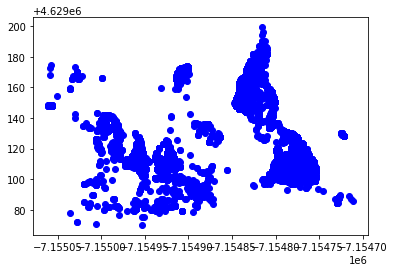

In [123]:
result = result.select("pca_features")
cols = result.collect()
cols = np.asarray([x[0] for x in cols])
plt.scatter(cols[:, 0], cols[:, 1], color = 'b')

plt.show()

For this question we get that somes features like 'w' or 'metro' aren't enough informative to get acceptable clusters for our data.

Also we saw that features like 'ppi' and 'pxratio' contain too much null value to be informative.

After many attemps we get that PCA method successfully cluster the data into 2 or 3 clusters (the amount on the left and the group of the right that can also be divided into two groups).

# Question 3 – Unsupervised Learning 


In [129]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import LDA

In [130]:
KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(dataset2)
KMeans_Assignments=KMeans_Model.transform(dataset2)

In [131]:
x_pca = np.array(result.rdd.map(lambda row: row.pca_features).collect())
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
pca_data = np.hstack((x_pca,cluster_assignment))

In [132]:
#np.set_printoptions(threshold=20)
pca_data

array([[-7.15477156e+06,  4.62912199e+06,  2.00000000e+00],
       [-7.15492867e+06,  4.62911079e+06,  1.00000000e+00],
       [-7.15492953e+06,  4.62910158e+06,  1.00000000e+00],
       ...,
       [-7.15480415e+06,  4.62910455e+06,  2.00000000e+00],
       [-7.15475625e+06,  4.62910998e+06,  2.00000000e+00],
       [-7.15479509e+06,  4.62910918e+06,  2.00000000e+00]])

# Question 4 – Results Exploration


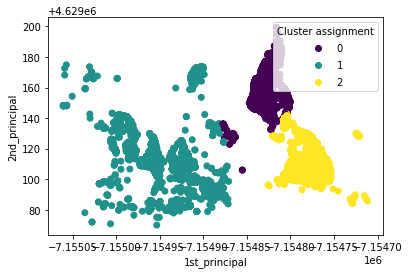

In [133]:
a = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_data[:, 3])
plt.xlabel('1st_principal')
plt.ylabel('2nd_principal')
legend1 = plt.legend(*a.legend_elements(),
                    loc="upper right", title="Cluster assignment")
plt.show()

Our results show that the K-Means algorithm successfully divided the data based on the separation observed in the PCA from question 2. This is because our chosen features included both categorical and continuous variables. To represent the categorical features, we applied one hot encoding, which resulted in many sparse vectors.

In the PCA algorithm, the continuous features had a greater impact on the results because they can be easily compared to one another. On the other hand, the categorical features represent distinct groups and their values are not directly comparable. For example, it is not possible to directly compare two languages or models.

Additionally, the categorical vectors transformed through one hot encoding had very little variance and likely had a lesser effect on the PCA algorithm compared to the continuous features, particularly the feature representing the ad area. This feature may indicate the size of the device used, and it is reasonable to assume that a larger ad area would correspond to a higher bidfloor value.

Comparison between the two algorithms:

We use PCA to reduce the dimensionality of the data and to create a graph for analyzing the different groups it contains. In contrast, the K-Means algorithm required us to specify the number of groups in advance that we wanted the data to be divided into.

PCA created groups of the main components that capture the maximum variance of the data, while K-Means created a separation based on the similarity of the data. Both algorithms were used to divide our data and can be used to study and identify patterns within the data.